<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lasciate ogne speranza, voi ch'intrate**

This is a research scratchpad; it's not designed to be read but rather evolved to test ideas. Please reach out if you'd like a guided tour. 



In [1]:
import itertools
import os

import numpy as np
pi = np.pi

!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html -U

import torch as T
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator
from scipy.linalg import toeplitz
from scipy.optimize import minimize_scalar
from scipy.ndimage import rotate
from google.colab import output
!pip install torchdiffeq
!pip install --quiet tensorfont
!pip install --quiet fonttools
!pip install --quiet --upgrade fontParts
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
#!pip install --quiet --upgrade anisotropic-distance-transform
import fontParts
import extractor
import defcon
from torchdiffeq import odeint_adjoint as odeint
#import adt
from ufo2ft import compileOTF

from tensorfont import Font

dev = T.device('cuda' if T.cuda.is_available() else 'cpu')
print("✓ Dependencies imported.")

Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.9.0.dev20210326+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.10.0.dev20210326+cu101)
✓ Dependencies imported.


In [2]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [3]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
#glyph_char_list = "bdghijlmxnopqu" # straight letters only
#glyph_char_list = "abgjqrstxc"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
#glyph_char_list = "axcy"

# ==== Create Font ====
factor = 1.0 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)
pi = np.float32(np.pi)

batch_size = 1
sample_distance_deltas = [-3, -1, 0, 1, 5]
sample_distance_factors = [.8, 1., 2.0]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 10
n_b_scales = 1
n_v1_orientations = 8
n_v4_scales = 8
n_g_scales = n_v1_scales

scale_factor = .02
scale_base = (.6 / scale_factor) ** (1 / (n_g_scales + 3))

# ==== Load glyph images ====

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)

100%|██████████| 26/26 [00:00<00:00, 960.51it/s]

Box size: 80 × 161
  ✓ 26 glyphs rendered.



100%|██████████| 26/26 [00:00<00:00, 13100.90it/s]

  ✓ 26 glyphs measured.


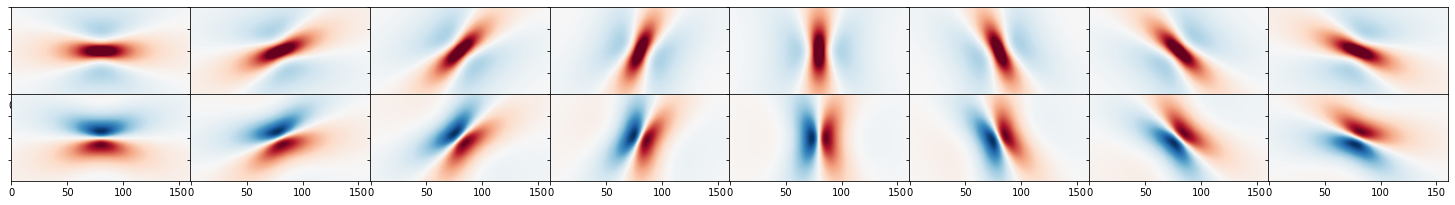

In [4]:
def unit_pgrid(keep_aspect_ratio=False):  # polar grid
    """Generate a meshgrid and rotate it by RotRad radians."""
    y, x = T.meshgrid(T.arange(-box_height, box_height, dtype=T.float32),
                      T.arange(-box_width, box_width, dtype=T.float32)) 
    y = y / box_height
    x = x / (box_width if keep_aspect_ratio else box_height)
     
    r = T.sqrt(x**2 + y**2)
    angle = T.atan2(x, y)
    angle = T.where(angle<0 , 2*pi+angle, angle)
    return r, angle


def get_sigmas(skip_scales=0):
    sigmas = []
    for s in range(n_v1_scales):
        sigmas.append(scale_factor * scale_base ** s)
    return T.tensor(sigmas)

def get_v1_filter_bank(skip_scales, display_filters=False, display_fft=False):
    r, angle = unit_pgrid(True)
    unit_freqs = r
    unit_freqs[box_height, box_width] = 1.
    lowpassfilter = 1.0 / (1.0 + (unit_freqs / 0.9)**20)

    if False:
        print("We cut off the frequencies in the corners to get a smoother filter, using this mask:")
        plt.imshow(lowpassfilter)
        plt.colorbar()
        plt.show()

    bandwidth = 0.75
    def get_filter_log_gabor(s, theta):
        target_period = 1/s
        freq_ring = T.exp(-(T.log(unit_freqs * target_period))**2) / (2 * np.log(bandwidth)**2)
        freq_ring[box_height, box_width] = 0

        # Remove the corners of the FFT by passing through a large circle with round edges
        freq_ring *= lowpassfilter

        # Now for the angular filter, we can use a von Mises function. We only want this to go around one side, only on the positive real.
        k = 8
        angular_filter = T.exp(k * T.cos(angle - theta*pi/n_v1_orientations)) / (2*pi*np.i0(k))

        real_filter = freq_ring * angular_filter

        # We want the same energy in every filter. How do we achieve this? We want to take the area that it covers in the FFT and make the max equal to one.
        return T.fft.ifftshift(-real_filter + 0j)

    filter_bank = T.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width), dtype=T.complex64)

    if display_filters:
        sizediv = 50
        #fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))
        fig, ax = plt.subplots(2, n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, 2*box_height / sizediv))

    sigmas = get_sigmas()
    totalfilter = 0
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter_log_gabor(sigma, o)
            if display_filters and s == 0:
                mx = T.max(T.abs(T.imag(T.fft.ifft2(f))))
                ax[0,o].imshow(T.real(T.fft.fftshift(T.fft.ifft2(f)))[int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                       int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], cmap="RdBu", vmin=-mx, vmax=mx)
                ax[0,o].set_aspect("auto")
                ax[0,o].set_yticklabels([])
                ax[1,o].imshow(T.imag(T.fft.fftshift(T.fft.ifft2(f)))[int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                     int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], cmap="RdBu", vmin=-mx, vmax=mx)
                ax[1,o].set_aspect("auto")
                ax[1,o].set_yticklabels([])
            if display_fft:
                totalfilter += T.fft.fftshift(f)
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()
    if display_fft:
        plt.imshow(T.real(totalfilter))
        plt.colorbar()
        plt.show()
        plt.imshow(T.imag(totalfilter))
        plt.colorbar()
        plt.show()

    return filter_bank

filter_bank = get_v1_filter_bank(0, display_filters=True, display_fft=False)


def apply_filter_bank(input_image, filter_bank, invert=False):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    fbs = filter_bank.shape[-2:]
    if invert:
        bsohwd_input_image = input_image[None, None, :, :, :, :]
        input_in_freqdomain = T.fft.fft2(bsohwd_input_image, s=fbs)
        padded_result = T.fft.ifft2(T.sum(input_in_freqdomain, dim=[2, 3]))
        return padded_result[0, 0, :box_height, :box_width]
    else:
        bdsohw_input_image = input_image[None, None, None, None, :, :]
        input_in_freqdomain = T.fft.fft2(T.tensor(np.array(bdsohw_input_image) + 0j, dtype=T.complex64), s=fbs)
        padded_result = T.fft.ifft2(input_in_freqdomain * filter_bank[None, None, :, :, :, :])
        return padded_result[0, 0, :, :, :box_height, :box_width]


ring rs [0.02       0.02598093 0.03375043 0.04384339 0.0569546  0.07398667
 0.09611212 0.12485411 0.16219133 0.21069407 0.2737014  0.35555083]


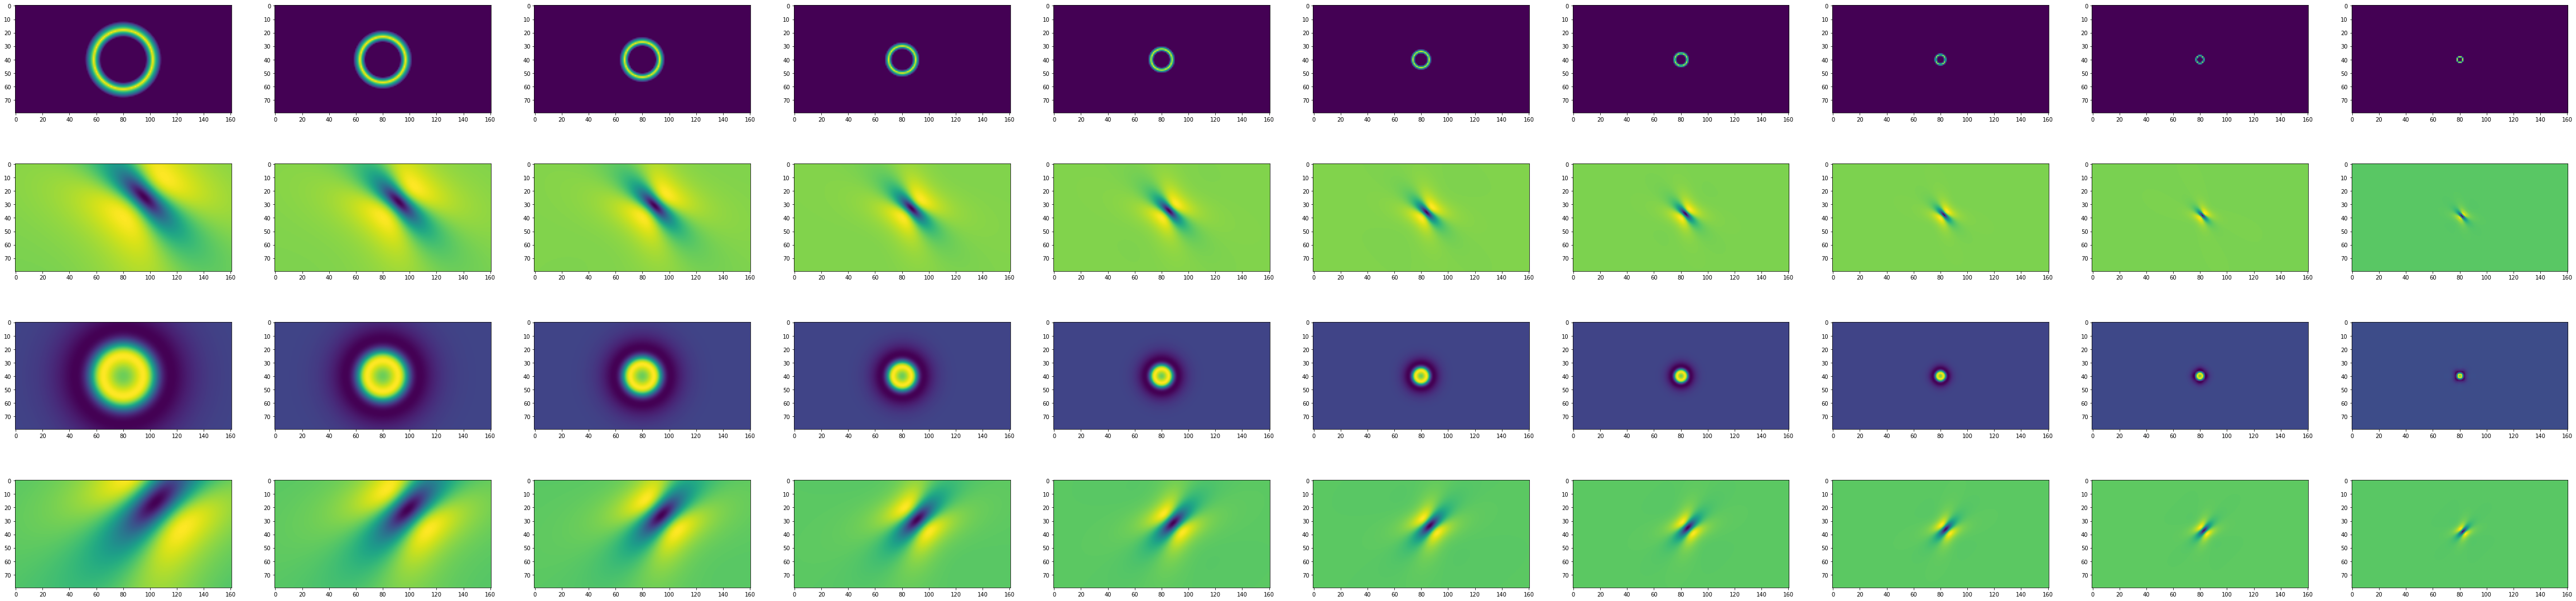

In [5]:
class G_filters(T.nn.Module):
    """
    Creates the annular G-cell filters, one set for each phase.
    Returns: <s, o, p, h, w>
    """
    def __init__(self):
        super().__init__()
        self.r, self.angle = unit_pgrid()
        self.r = self.r.to(dev)
        self.angle = self.angle.to(dev)

        self.bp_angle_masks, self.bn_angle_masks = self.make_angle_masks()

    def make_angle_masks(self):
        angle = self.angle[None, None, :, :].to(dev) # <o, c, h, w>
        angles = T.arange(n_v1_orientations, dtype=T.float32, device=dev)[:, None, None, None]/n_v1_orientations

        # Uses von-Mises distribution (via Bessel function)
        angle_mask_widths = 16.
        bp_angle_masks = T.exp(-angle_mask_widths * T.cos(angle - pi - pi * angles)) / (2*pi*np.i0(angle_mask_widths))
        bn_angle_masks = T.exp(-angle_mask_widths * T.cos(angle - pi * angles)) / (2*pi*np.i0(angle_mask_widths))

        return bp_angle_masks, bn_angle_masks

    def make_radial_masks(self):
        ring_rs = scale_factor * scale_base ** T.arange(n_g_scales + 2).to(dev) # makes it <c=8, p=4>
        ray_rs = scale_factor * scale_base ** T.arange(n_g_scales + 5).to(dev) # makes it <c=8, p=4>

        print("ring rs", ring_rs.detach().cpu().numpy())
        ring_radial_masks = T.zeros((1, n_g_scales, 2*box_height, 2*box_width)).to(dev)
        ray_radial_masks = T.zeros((1, n_g_scales, 2*box_height, 2*box_width)).to(dev)

        def triangle_distribution(a, c, b):
            updiagonal = 2*(self.r - a) / ((b-a)*(c-a))
            downdiagonal = 2*(b-self.r) / ((b-a)*(b-c))
            return F.relu(T.minimum(updiagonal, downdiagonal))

        for i in range(n_g_scales):
            ring_radial_masks[:, i, :, :] = triangle_distribution(ring_rs[i], ring_rs[i + 1], ring_rs[i + 2])[None, :, :]  # make it <o, c, p, h, w>
            ray_radial_masks[:, i, :, :] = triangle_distribution(ray_rs[i], ray_rs[i + 3], ray_rs[i + 4])[None, :, :]  # make it <o, c, p, h, w>
    
        return T.flip(ring_radial_masks, dims=[1]), T.flip(ray_radial_masks, dims=[1])  # We actually want to start with the biggest radius, because the first V1 filter is the largest, too

    def forward(self): # Returns masks of shape <o, c, h, w>
        #print("G params", [p.T.detach().cpu().numpy() for p in self.parameters()])

        ring_radial_masks, ray_radial_masks = self.make_radial_masks()

        def assemble_masks(radial_masks):
            bp_masks = radial_masks * self.bp_angle_masks
            bn_masks = radial_masks * self.bn_angle_masks
        
            eps = 1e-10   # Each bp/bn_mask fragment should add up to exactly one:
            bp_masks_normed = 4*bp_masks / (eps + T.sum(F.relu(bp_masks), (0, -2, -1), keepdims=True))
            bn_masks_normed = 4*bn_masks / (eps + T.sum(F.relu(bn_masks), (0, -2, -1), keepdims=True))
            return T.einsum("ochw->cohw", T.clip(T.cat([bp_masks_normed, bn_masks_normed], axis=0), -1e12, 1e12))
        
        return assemble_masks(ring_radial_masks), assemble_masks(ray_radial_masks)

def test_G_filters():
    ring_gf, ray_gf = G_filters().to(dev)()  # create and run, in one go

    if False:
        gf = ring_gf + ray_gf
        fig, ax = plt.subplots(1, n_g_scales, figsize=[82, 35], constrained_layout=True)
        ax[0].set_title("G filters")
        for i in range(n_g_scales):
            ax[i].imshow(np.sum(gf.detach().cpu().numpy()[i, :,   
                                            int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                            int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], (0)))
        plt.show()
    
        fig, ax = plt.subplots(1, 2*n_v1_orientations, figsize=[22, 9], constrained_layout=True)
        ax[0].set_title("G filters")
        for i in range(2*n_v1_orientations):
            ax[i].imshow(gf.detach().cpu().numpy()[0, i,   
                                            int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                            int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))])
        plt.show()

    # we want to replace each pixel of each piece with the relevant V1 filters.
    # V1 filters are I<sohw>, these are <ocphw>.
    # let's take the 1st phase
    fbr = T.real(T.fft.fftshift(T.fft.ifft2(filter_bank), [-2, -1])).to(dev)
    fbi = T.imag(T.fft.fftshift(T.fft.ifft2(filter_bank), [-2, -1])).to(dev)
    fbrf = T.fft.fft2(fbr).to(dev) # <sohw>
    fbif = T.fft.fft2(fbi).to(dev) # <sohw>
    fbrfr = T.cat([fbrf, fbrf], axis=1).to(dev)
    fbifr = T.cat([fbif, -fbif], axis=1).to(dev)
    gbring = T.fft.fft2(T.fft.ifftshift(ring_gf, [-2, -1])).to(dev) # <sohw>
    gbray = T.fft.fft2(T.fft.ifftshift(ray_gf, [-2, -1])).to(dev) # <sohw>

    rendered_rings_real = T.real(T.fft.ifft2(fbrfr * gbring))
    rendered_rings_imag = T.real(T.fft.ifft2(fbifr * gbring))
    rendered_rays_imag = T.real(T.fft.ifft2(T.roll(fbrfr, 4, 1) * gbray))

    fig, ax = plt.subplots(4, n_g_scales, figsize=[82, 20]) #, constrained_layout=True)
    for i in range(n_g_scales):
        ax[0, i].imshow(np.sum(ring_gf.detach().cpu().numpy()[i, :,
                                        int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], (0)))
        ax[1, i].imshow(np.sum(rendered_rings_real.detach().cpu().numpy()[i, 6:7,   
                                        int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], (0)))
        ax[2, i].imshow(np.sum(rendered_rings_imag.detach().cpu().numpy()[i, :,   
                                        int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], (0)))
        ax[3, i].imshow(np.sum(rendered_rays_imag.detach().cpu().numpy()[i, 6:7,   
                                        int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], (0)))
    plt.show()
    

test_G_filters()

ring rs [0.02       0.02598093 0.03375043 0.04384339 0.0569546  0.07398667
 0.09611212 0.12485411 0.16219133 0.21069407 0.2737014  0.35555083]
BG Direct parameters:


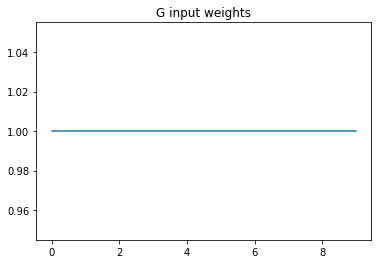

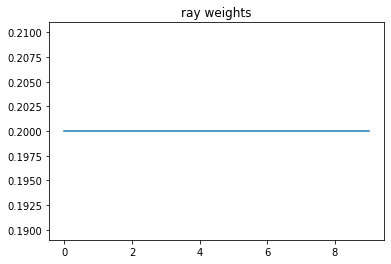

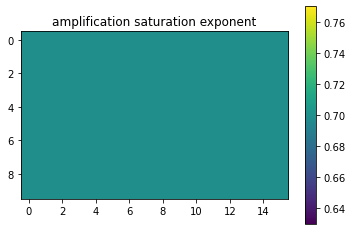

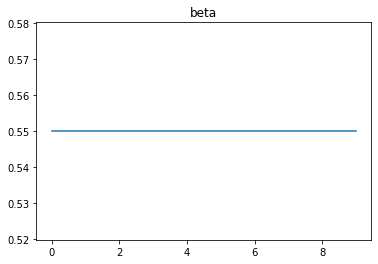

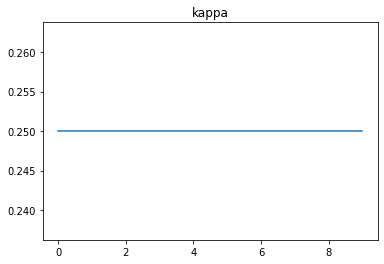

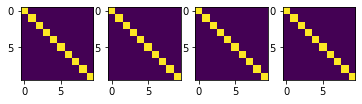

In [6]:
class B_G_Direct(T.nn.Module):
    def __init__(self):
        super().__init__()

        self.g_ring_filters, self.g_ray_filters = G_filters().to(dev)()
        self.g_ring_filters_fft = T.fft.fft2(T.fft.ifftshift(self.g_ring_filters + 0j, [-2, -1])).to(dev)
        self.g_ray_filters_fft = T.fft.fft2(T.fft.ifftshift(self.g_ray_filters + 0j, [-2, -1])).to(dev)
        self.g_ring_filters_inverse_fft = T.roll(self.g_ring_filters_fft, [n_v1_orientations], dims=[-3]).to(dev)

        self.b_to_g = T.nn.Parameter(T.tile(T.eye(n_v1_scales)[:, :, None], [1, 1, 4]).to(dev))
        #self.b_to_g = T.tile(T.eye(n_v1_scales)[:, :, None], [1, 1, 4]).to(dev)

        self.G_input_weight = T.nn.Parameter(T.tensor([1.0] * n_v1_scales).to(dev)[:, None, None, None])
        self.ray_weight = T.nn.Parameter(T.tensor([0.2] * n_v1_scales).to(dev)[:, None, None])
        self.amplification_saturation = T.nn.Parameter(0.7 * T.ones((n_v1_scales, 2*n_v1_orientations)).to(dev)[:, :, None, None, None])
        self.k = T.nn.Parameter(T.tensor([.25] * n_v1_scales).to(dev)[:, None, None, None, None])
        self.b = T.nn.Parameter(T.tensor([.55] * n_v1_scales).to(dev)[:, None, None, None, None])

    def conv_b_to_g(self, b):
        """Projection upwards from B to G cells. <bd sohw> → <bd shw>"""

        b_fft = T.fft.fft2(b + 0j, s=self.g_ring_filters_fft.shape[-2:])
        result = T.real(T.fft.ifft2(b_fft * self.g_ring_filters_fft))[..., :b.shape[-2], :b.shape[-1]]
        return T.sum(result, dim=[-3]) # sum over all incoming orientations

    def conv_b_to_g_rays(self, b):
        """Projection of rays upwards from B to G cells. <bd sohw> → <bd shw>"""

        b_fft = T.fft.fft2(b + 0j, s=self.g_ray_filters_fft.shape[-2:])
        result = T.real(T.fft.ifft2(T.roll(b_fft, int(n_v1_orientations/2), -4) * self.g_ray_filters_fft))[..., :b.shape[-2], :b.shape[-1]]
        return T.sum(result, dim=[-3]) # sum over all incoming orientations

    def get_g_inputs(self, b):
        """Collect inputs from B cells for all four phases. <bd sophw> → <bd sphw>.
           Also collect from the rays.
        """
        gi0 = self.conv_b_to_g(b[..., 0, :, :]) # wbw
        gi1 = self.conv_b_to_g(T.cat([b[..., :n_v1_orientations, 1, :, :], b[..., n_v1_orientations:, 3, :, :]], dim=-3))  # bw
        gi2 = self.conv_b_to_g(b[..., 2, :, :]) # bwb
        gi3 = self.conv_b_to_g(T.cat([b[..., :n_v1_orientations, 3, :, :], b[..., n_v1_orientations:, 1, :, :]], dim=-3))  # wb

        rays1 = self.conv_b_to_g_rays(T.cat([b[..., :n_v1_orientations, 1, :, :], b[..., n_v1_orientations:, 3, :, :]], dim=-3))  # bw

        if False:
            plt.imshow(self.conv_b_to_g(T.cat([b[:, :n_v1_orientations, 1, :, :], T.zeros_like(b[:, :n_v1_orientations, 0, :, :])], dim=-3))[2, :, :].detach().cpu().numpy())
            plt.title("g from scale 2 phase 0 down")
            plt.colorbar()
            plt.show()

        return T.stack([gi0, gi1 + self.ray_weight * rays1, gi2, gi3], dim=-3) # stack phases together

    def conv_g_to_b(self, g):
        """Projection downwards from G to B cells. <bd sphw> → <bd sohw>"""

        g_fft = T.fft.fft2(g, s=self.g_ring_filters_inverse_fft.shape[-2:])[..., None, :, :, :]  # insert empty o dimension for <bd sophw>
        result = T.real(T.fft.ifft2(g_fft * self.g_ring_filters_inverse_fft[..., None, :, :]))[..., :g.shape[-2], :g.shape[-1]]  # does this broadcast correctly, aligned at the end? hopefully ...
        return result  # <bd sophw>, where o is doubled up and will need to be split up

    def get_b_amplification(self, g):
        """Collect inputs from G to B cells for all four phases. <bd sphw> → <bd sophw>"""
        
        projections = self.conv_g_to_b(g)

        # Now we need to split these projections <bd sophw> back into the phases they came from, to get the gain factors for <bd sophw> 
        # This works naturally for phases 0 and 2, but for 1 and 3 it will be wrong.
        p0 = projections[..., 0, :, :]
        p1 = T.cat([projections[..., :n_v1_orientations, 1, :, :], projections[..., n_v1_orientations:, 3, :, :]], dim=-3) # is 
        p2 = projections[..., 2, :, :]
        p3 = T.cat([projections[..., :n_v1_orientations, 3, :, :], projections[..., n_v1_orientations:, 1, :, :]], dim=-3)

        return T.stack([p0, p1, p2, p3], dim=-3) 

    def normalize_b(self, b, pretend_zero_competition=False):
        """Find the opposites of the respective B cells."""

        # Normalization pool: let's say it's equal for now; in the future we can build a parameter matrix.
        # Normalization pool: for each phase, double up the top and bottom orientations

        kappa = self.k * 10
        kappa += (T.randn_like(kappa) * F.relu(kappa) / 46).detach()
        kappa = F.softplus(kappa, 1000)
        beta = self.b * 10
        beta += (T.randn_like(beta) * F.relu(beta) / 46).detach()
        beta = F.softplus(beta, 1000)

        b_s = F.relu(b) + 1e-8  # sanitized version of b, in case some negatives snuck in there

        if not pretend_zero_competition:
            # rotate b by 180, then double it up (so that itself is also included)
            pool = b_s[..., n_v1_orientations:, :, :, :] ** kappa + b_s[..., :n_v1_orientations, :, :, :] ** kappa
            pool = beta + T.cat([pool] * 2, dim=-4)
        else:
            # only include itself
            pool = beta + 2*b_s**kappa
        return b_s ** kappa / pool


    def forward(self, b, plot):
        # b: <bd sophw>  p = phase (4), and o=2*n_v1_orientations
        # g: <bd sphw>  p = phase (4)

        # First, we will create a cross between different B cells such that each G cell is interacting with the right range of B cells.
        # Hopefully there won't be too much wrongful interaction.
        # We can ensure this by making sure each B cell scale is captured by only one G cell in total.
        b = T.einsum("bdsophw,sgp->bdgophw", b, F.softplus(self.b_to_g, 1000) / T.sum(F.softplus(self.b_to_g, 1000), dim=[1], keepdim=True))

        # Apply some noise to the B cells, to help prevent overfitting.
        # We first blur every layer in b by one across b and g
        b += (T.randn_like(b) * F.relu(b) / 36).detach()

        # So, what are the relationships between the respective neurons here?
        # First, we want to compute the respective G cell excitation caused by the G cells

        # First, the even part (rp=Mexican hat, rn=inverse Mexican hat).
        # Each G cell takes either from
        giw = self.G_input_weight * 10
        giw += (T.randn_like(giw) * F.relu(giw) / 36).detach()

        g = F.softplus(giw, 1000) * self.get_g_inputs(b)  # <bd sphw>

        b_amplification = self.get_b_amplification(g)

        sas = F.softplus(self.amplification_saturation + (T.randn_like(self.amplification_saturation.detach()) * F.relu(self.amplification_saturation.detach()) / 48).detach(), 100)

        # Now, apply the b_amplification
        b_amplified = b * (1 + b_amplification) ** sas

        # Now, perform divisive normalization between opponent B cells
        b_normalized_amplified = self.normalize_b(b_amplified)
        b_normalized_amplified_pretend_zero_competition = self.normalize_b(b_amplified, True)

        # we want to know how much this G cell would be capable of, if there hadn't been competition from its B-cell opponents.
        # So the bigger the difference, the more this thing is hampered by its competition.

        # Now recompute the G cells from the B cells
        g_normalized_amplified = F.softplus(giw, 1000) * self.get_g_inputs(b_normalized_amplified)
        g_normalized_amplified_pretend_zero_competition = F.softplus(giw, 1000) * self.get_g_inputs(b_normalized_amplified_pretend_zero_competition)

        g_stability = g_normalized_amplified / (g_normalized_amplified_pretend_zero_competition + 1e-5)

        if plot:
            si = 4
            pi = 3
            if False:
                plt.imshow(glyph_images[glyph_char_list[0]], cmap="gray")
                plt.imshow(g_normalized_amplified[0, 0, si, pi, :, :].detach().cpu().numpy(), alpha=.9)
                plt.title("amplified")
                plt.colorbar()
                plt.show()
                plt.imshow(glyph_images[glyph_char_list[0]], cmap="gray")
                plt.imshow(g_normalized_amplified_pretend_zero_competition[0, 0, si, pi, :, :].detach().cpu().numpy(), alpha=.9)
                plt.title("unamplified")
                plt.colorbar()
                plt.show()
                plt.imshow(glyph_images[glyph_char_list[0]], cmap="gray")
                plt.imshow(g_stability[0, 0, si, pi, :, :].detach().cpu().numpy(), alpha=.9)
                plt.title("stability")
                plt.colorbar()
                plt.show()

            print("BG Direct parameters:")

            plt.plot(self.G_input_weight[:, 0, 0 ,0].detach().cpu().numpy())
            plt.title("G input weights")
            plt.show()
            plt.plot(self.ray_weight[:, 0 ,0].detach().cpu().numpy())
            plt.title("ray weights")
            plt.show()
            plt.imshow(F.softplus(self.amplification_saturation, 100)[:, :, 0, 0 ,0].detach().cpu().numpy())
            plt.imshow(F.softplus(self.amplification_saturation, 100)[:, :, 0, 0 ,0].detach().cpu().numpy())
            plt.colorbar()
            plt.title("amplification saturation exponent")
            plt.show()
            plt.plot(F.softplus(self.b, 100)[:, 0, 0, 0 ,0].detach().cpu().numpy())
            plt.title("beta")
            plt.show()
            plt.plot(F.softplus(self.k, 100)[:, 0, 0, 0 ,0].detach().cpu().numpy())
            plt.title("kappa")
            plt.show()
            fig, ax = plt.subplots(1, 4)
            for pi in range(4):
                ax[pi].imshow(F.softplus(self.b_to_g[:, :, pi], 100).detach().cpu().numpy())
            plt.show()

        return (b_normalized_amplified, g_normalized_amplified, g_stability)

def test_amplification():

    p1 = apply_filter_bank(-glyph_images[glyph_char_list[0]], filter_bank)[None, None, ...]

    b_doubled = T.cat([p1] * 2, dim=-3).to(dev)  # double up the B cells along the orientation axis
    b_initial = T.stack([F.relu(T.real(b_doubled)),
                         F.relu(T.imag(b_doubled)),
                         F.relu(-T.real(b_doubled)),
                         F.relu(-T.imag(b_doubled))], axis=-3).to(dev)

    # This is really annoying, but we need to split up the filters into real and imaginary,
    # because of a limitation of odeint.
    
    bg_direct = B_G_Direct()
    b_out, g_out, g_stability = bg_direct(b_initial, True)

test_amplification()


In [7]:
class G_Targets(T.nn.Module):
    def __init__(self):
        super().__init__()

        atemplate = 0.01*T.ones((n_v1_scales, 4, 1, 1))
        #atemplate[3:, ...] = 0.
        #atemplate[:2, ...] = 0.

        self.target_a = T.nn.Parameter(atemplate)  # <sphw>
        self.target_b = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.target_c = T.nn.Parameter(0.01*T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.target_d = T.nn.Parameter(T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.target_s = T.nn.Parameter(T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.tolerance_a = T.nn.Parameter(atemplate)  # <sphw>
        self.tolerance_b = T.nn.Parameter(0.01*T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.tolerance_c = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.tolerance_d = T.nn.Parameter(0.1*T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.tolerance_s = T.nn.Parameter(T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>

        self.loss_factor = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.loss_exponent = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.loss_original_exponent = T.nn.Parameter(0.01*T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.gain_k = T.nn.Parameter(2 * T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.gain_b = T.nn.Parameter(.3 * T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.gain_factor = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.gain_exponent = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.general_exp = T.nn.Parameter(1.5*T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>

        with T.no_grad():
            self.g_scales = T.tile(T.arange(n_v1_scales)[None, None, :, None, None, None], # <b d s p h w>
                                   [batch_size, n_sample_distances, 1, 4, box_height, box_width]).to(dev)

        # we want initially constant. so 0.01, 0.01, 0.2
        partemp = T.stack([0.001*T.ones((1, 1, 1, 4, 1, 1, 8)), 0.001*T.ones((1, 1, 1, 4, 1, 1, 8)), 0.5*T.ones((1, 1, 1, 4, 1, 1, 8))], 0)
        self.pars = T.nn.Parameter(partemp)  # <bdsphwq> # so we have 10*4*7=280 params

        #self.targets_d1a = [T.nn.Linear(in_features=4, out_features=15).to(dev)] * 4
        #self.targets_d2a = [T.nn.Linear(in_features=15, out_features=4).to(dev)] * 4
        #self.targets_d3a = [T.nn.Linear(in_features=4, out_features=1).to(dev)] * 4
        #self.targets_d1b = [T.nn.Linear(in_features=4, out_features=15).to(dev)] * 4
        #self.targets_d2b = [T.nn.Linear(in_features=15, out_features=4).to(dev)] * 4
        #self.targets_d3b = [T.nn.Linear(in_features=4, out_features=1).to(dev)] * 4
        #self.targets_d1c = [T.nn.Linear(in_features=4, out_features=15).to(dev)] * 4
        #self.targets_d2c = [T.nn.Linear(in_features=15, out_features=4).to(dev)] * 4
        #self.targets_d3c = [T.nn.Linear(in_features=4, out_features=1).to(dev)] * 4
        #self.targets_d1d = [T.nn.Linear(in_features=4, out_features=15).to(dev)] * 4
        #self.targets_d2d = [T.nn.Linear(in_features=15, out_features=4).to(dev)] * 4
        #self.targets_d3d = [T.nn.Linear(in_features=4, out_features=1).to(dev)] * 4
        #self.do = T.nn.Dropout(.06)
        #self.tolerances_d1 = T.nn.Linear(in_features=3, out_features=60)
        #self.tolerances_d2 = T.nn.Linear(in_features=60, out_features=30)
        #self.tolerances_d3 = T.nn.Linear(in_features=30, out_features=1)

    def conv_g_to_b(self, g, g_filters_inverse_fft):
        # apply the ring convolution to the pairing of this <bd sphw> to make two <bd sohw>
        # by applying the ring segments in reverse
        g_fft = T.fft.fft2(g, s=g_filters_inverse_fft.shape[-2:])[..., None, :, :, :]  # insert empty o dimension for <bd sophw>
        result = T.real(T.fft.ifft2(g_fft * g_filters_inverse_fft[..., None, :, :]))[..., :g.shape[-2], :g.shape[-1]]  # does this broadcast correctly, aligned at the end? hopefully ...

        return result  # <bd sophw>, where o is double, ... but we need to split them up

    def get_b_gradient(self, g, g_filters_inverse_fft):
        # we have <bd sphw> and we want to get <bd sopchw>. So this is exactly the opposite as the above.
        # we get back <bd sophw>, and we would like 
        projections = self.conv_g_to_b(g, g_filters_inverse_fft)

        p0 = projections[..., :n_v1_orientations, 0, :, :] + projections[..., n_v1_orientations:, 0, :, :]
        p1 = projections[..., :n_v1_orientations, 1, :, :] + projections[..., n_v1_orientations:, 3, :, :]
        p2 = projections[..., :n_v1_orientations, 2, :, :] + projections[..., n_v1_orientations:, 2, :, :]
        p3 = projections[..., :n_v1_orientations, 3, :, :] + projections[..., n_v1_orientations:, 1, :, :]

        return T.stack([p0, p1, p2, p3], dim=-3)  # <bd sophw>

    def forward(self, inputs):
        (g1, g2, gp, plot) = inputs

        g1 = (F.relu(g1) + 1e-8) ** F.softplus(self.general_exp, 1000)
        g2 = (F.relu(g2) + 1e-8) ** F.softplus(self.general_exp, 1000)
        gp = (F.relu(gp) + 1e-8) ** F.softplus(self.general_exp, 1000)

        loss1 = F.softplus(self.loss_factor, 1000) * (F.relu(g1 - gp) + 1e-8) ** F.softplus(self.loss_exponent, 1000) * (F.relu(g2) + 1e-8) ** F.softplus(self.loss_original_exponent, 1000)
        loss2 = F.softplus(self.loss_factor, 1000) * (F.relu(g2 - gp) + 1e-8) ** F.softplus(self.loss_exponent, 1000) * (F.relu(g1) + 1e-8) ** F.softplus(self.loss_original_exponent, 1000)

        # gains: either reward only what was initiated by BOTH neurons,
        # or reward based on the difference between nonlinearized versions of both the inputs and the sum

        expected_sum = F.relu(g1 + g2) + 1e-8

        gain = F.softplus(self.gain_factor, 1000) * (F.relu(gp - expected_sum) + 1e-8) ** F.softplus(self.gain_exponent, 1000)

        if plot:
            vs = [
                  (F.softplus(self.general_exp, 1000), "general exp"),
                  (F.softplus(self.loss_factor, 1000), "loss factor"),
                  (F.softplus(self.loss_exponent, 1000), "loss exponent"),
                  (F.softplus(self.loss_original_exponent, 1000), "loss original exponent"),
                  (F.softplus(self.gain_factor, 1000), "gain factor"),
                  (F.softplus(self.gain_exponent, 1000), "gain exponent"),
                  ]
            for v, n in vs:
                plt.imshow(v.detach().cpu().numpy()[:, :, 0, 0])
                plt.title(n)
                plt.colorbar()
                plt.show()

        return (loss1 + loss2, gain)


def test_g_targets():
    gt = G_Targets().to(dev)
    s = T.zeros((batch_size, n_sample_distances, n_v1_scales, 4, box_height, box_width)).to(dev)
    _ = gt((s, s, s, s, True))
#test_g_targets()

In [8]:
class YinYangFit(T.nn.Module):
    def __init__(self):
        super().__init__()
        self.bg_direct = B_G_Direct()
        self.g_targets = G_Targets()

    def cleanup(self):
        del self.g_targets
        del self.bg_direct

    def apply_g_filters(self, image, plot):
        b_doubled = T.cat([image] * 2, dim=-3).to(dev)  # double up the B cells along the orientation axis
        b_initial = T.stack([F.relu(T.real(b_doubled)),
                             F.relu(T.imag(b_doubled)),
                             F.relu(-T.real(b_doubled)),
                             F.relu(-T.imag(b_doubled))], axis=-3).to(dev)
        
        b_out, g_out, g_stability = self.bg_direct(b_initial, plot)
        return (b_out, g_out, g_stability)

    def forward(self, inputs):
        p1, p2, g1, g2, plot = inputs

        # Get the G filters for the first letter, the second letter, and the 
        _, gr1, gs1, = self.apply_g_filters(p1, plot)
        _, gr2, gs2 = self.apply_g_filters(p2, False)
        _, grp, gsp = self.apply_g_filters(p1 + p2, False)

        losses, gains = self.g_targets((gr1 / 50, gr2 / 50, grp / 50, plot))

        penalties_total = losses + gains
        rt = T.sum(penalties_total, dim=[-4, -3, -2, -1]) 

        if plot:
            maxg = T.max(grp[0, 1, ...]).detach().cpu().numpy()
            print("g cells for both letters, max=", maxg)
            fig, ax = plt.subplots(n_v1_scales, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, n_v1_scales*box_height / 30))
            (t1, t2) = get_pair_translations(g1[0], g2[0], sample_distance_deltas)
            gi1, gi2 = T.tensor(glyph_images[g1[0]]).to(dev), T.tensor(glyph_images[g2[0]]).to(dev)
            git1, git2 = apply_translations(gi1, t1), apply_translations(gi2, t2)
            for i in range(n_v1_scales):
                ax[i, 0].imshow(grp[0, 1, i, 0, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 1].imshow(grp[0, 1, i, 1, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 2].imshow(grp[0, 1, i, 2, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 3].imshow(grp[0, 1, i, 3, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 0].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 1].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 2].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 3].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
            plt.show()

            maxg = T.max(losses[0, 1, ...]).detach().cpu().numpy()
            print("losses, max=", maxg)
            fig, ax = plt.subplots(n_v1_scales, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, n_v1_scales*box_height / 30))
            (t1, t2) = get_pair_translations(g1[0], g2[0], sample_distance_deltas)
            gi1, gi2 = T.tensor(glyph_images[g1[0]]).to(dev), T.tensor(glyph_images[g2[0]]).to(dev)
            git1, git2 = apply_translations(gi1, t1), apply_translations(gi2, t2)
            for i in range(n_v1_scales):
                ax[i, 0].imshow(losses[0, 1, i, 0, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 1].imshow(losses[0, 1, i, 1, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 2].imshow(losses[0, 1, i, 2, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 3].imshow(losses[0, 1, i, 3, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 0].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 1].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 2].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 3].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
            plt.show()

            maxg = T.max(gains[0, 1, ...]).detach().cpu().numpy()
            print("gains, max=", maxg)
            fig, ax = plt.subplots(n_v1_scales, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, n_v1_scales*box_height / 30))
            (t1, t2) = get_pair_translations(g1[0], g2[0], sample_distance_deltas)
            gi1, gi2 = T.tensor(glyph_images[g1[0]]).to(dev), T.tensor(glyph_images[g2[0]]).to(dev)
            git1, git2 = apply_translations(gi1, t1), apply_translations(gi2, t2)
            for i in range(n_v1_scales):
                ax[i, 0].imshow(gains[0, 1, i, 0, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 1].imshow(gains[0, 1, i, 1, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 2].imshow(gains[0, 1, i, 2, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 3].imshow(gains[0, 1, i, 3, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 0].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 1].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 2].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 3].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
            plt.show()

            maxg = T.max(penalties_total[0, 1, ...]).detach().cpu().numpy()
            print("total penalties, max=", maxg)
            fig, ax = plt.subplots(n_v1_scales, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, n_v1_scales*box_height / 30))
            (t1, t2) = get_pair_translations(g1[0], g2[0], sample_distance_deltas)
            gi1, gi2 = T.tensor(glyph_images[g1[0]]).to(dev), T.tensor(glyph_images[g2[0]]).to(dev)
            git1, git2 = apply_translations(gi1, t1), apply_translations(gi2, t2)
            for i in range(n_v1_scales):
                ax[i, 0].imshow(penalties_total[0, 1, i, 0, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 1].imshow(penalties_total[0, 1, i, 1, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 2].imshow(penalties_total[0, 1, i, 2, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 3].imshow(penalties_total[0, 1, i, 3, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 0].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 1].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 2].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 3].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
            plt.show()

            plt.imshow((git1 + git2)[1, ...].detach().cpu().numpy(), cmap="gray")
            plt.imshow(T.sum(penalties_total[0, 1, :, :, :, :], dim=[0, 1]).detach().cpu().numpy(), alpha=0.9)
            plt.title("total rewards/penalty")
            plt.colorbar()
            plt.show()

        return rt


In [9]:
def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance * np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)

#print("  ✓ Pair translations test,", get_pair_translations("x", "a", [-2, 0, 5]))

In [10]:
def apply_translations(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, [phases], height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, [phases], height, width>
    """

    images = T.tile(input_image[None, ...], [translations.shape[0]] + [1] * len(input_image.shape)) # create len(shifts) channel copies
    fill_constant = 0
    left_pad = np.maximum(0, np.max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right_pad = np.maximum(0, -np.min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = T.zeros(images.shape[:-1] + (left_pad,), dtype=images.dtype).to(dev)
    right_mask = T.zeros(images.shape[:-1] + (right_pad,), dtype=images.dtype).to(dev)
    padded_images = T.cat([left_mask, images, right_mask], dim=-1) # pad on last axis (i.e. width-wise)

    for i, t in enumerate(translations):
        left_x = left_pad - t
        right_x = left_pad - t + input_image.shape[-1]
        images[i, ...] = padded_images[i, ..., left_x:right_x]

    return images

In [11]:
class GlyphPairs(T.utils.data.Dataset):
    def __init__(self, end_time):
        super().__init__()
        # We perform the V1 filtering for all of the glyphs first.

        self.v1_responses = {c: apply_filter_bank(-glyph_images[c], filter_bank, invert=False) for c in tqdm(glyph_char_list)}

        #self.b_g_differential = B_G_Differential().to(dev)
        self.end_time = end_time

        self.pg_cache = {}
        self.bg_direct = B_G_Direct()

    def __len__(self):
        # The total number of pairs available
        return len(glyph_char_list) ** 2

    def cleanup(self):
        #del self.b_g_differential
        del self.bg_direct
        del self.v1_responses
        del self.pg_cache

    def __getitem__(self, idx):
        # Convert the idx into first and last letter
        g1 = glyph_char_list[idx // len(glyph_char_list)]
        g2 = glyph_char_list[idx % len(glyph_char_list)]

        i1, i2 = self.v1_responses[g1].to(dev), self.v1_responses[g2].to(dev)
        print("Generating pair", g1, g2, " ...", flush=True)
        #with T.no_grad():
        # Shift the letters accordingly to the necessary pair translations
        (t1, t2) = get_pair_translations(g1, g2, sample_distance_deltas)

        # Return three pairs of complex-valued, horizontally shifted images, <d sohw>
        p1, p2 = apply_translations(i1, t1), apply_translations(i2, t2)

        if False: 
            gi1, gi2 = T.tensor(glyph_images[g1]).to(dev), T.tensor(glyph_images[g2]).to(dev)
            git1, git2 = apply_translations(gi1, t1), apply_translations(gi2, t2)
            fig, ax = plt.subplots(1, 3, figsize=(15,5))
            ax[0].imshow((git1 + git2)[0, :, :].detach().cpu().numpy())
            ax[1].imshow((git1 + git2)[1, :, :].detach().cpu().numpy())
            ax[2].imshow((git1 + git2)[2, :, :].detach().cpu().numpy())
            plt.show()

        if False:
            pg1, pg2 = apply_translations(self.pg_cache[g1], t1), apply_translations(self.pg_cache[g2], t2)

        label = T.tensor(2, dtype=T.long).to(dev) # this is the index of the right choice

        return [g1, g2, p1.to(dev), p2.to(dev), label]



In [12]:
ce_criterion = T.nn.CrossEntropyLoss()

def estimate_min_loss(p): # where p are the penalties

    d0, d1, d2, d3 = p[0, 0] > p[0, 1], p[0, 1] > p[0, 2], p[0, 2] > p[0, 3], p[0, 3] > p[0, 4]
    inv1 = d0 and (not d1) and (not d2) and (not d3)
    inv2 = d0 and d1 and (not d2) and (not d3)
    inv3 = d0 and d1 and d2 and (not d3)

    if inv1 or inv2 or inv3:
        # estimate the minimum, and the loss shall be the squared distance from zero.
        xs = T.tensor(sample_distance_deltas, dtype=T.float)
        A = T.stack([xs**3, xs**2, xs, xs**0], -1).to(dev)
        b = p[0, :, None]

        coeffs = A.pinverse() @ b
        coeffs = coeffs[0:4, 0]

        sq_a, sq_b, sq_c = 3*coeffs[0], 2*coeffs[1], coeffs[2]

        min_est_1 = (-sq_b + T.sqrt(sq_b**2 - 4*sq_a*sq_c)) / (2*sq_a)
        min_est_2 = (-sq_b - T.sqrt(sq_b**2 - 4*sq_a*sq_c)) / (2*sq_a)

        # which one is the minimum?
        li_a, li_b = 2*sq_a, sq_b

        if (li_a * min_est_1 + sq_b).item() > 0: # if the first one has a positive curvature
            loss = (min_est_1 ** 2)
        else:
            loss = (min_est_2 ** 2)

        print("Horizontal loss estimate:", loss.detach().cpu().numpy(), "DEVIATION:", T.sqrt(loss).detach().cpu().numpy(), p.detach().cpu().numpy())

    else:
        # treat it as a category thing, where the center is the target category.
        loss = ce_criterion(-p, T.tensor(2, dtype=T.long).to(dev)[None])
        print("Categorical loss:", loss.detach().cpu().numpy(), p.detach().cpu().numpy())

    return loss

estimate_min_loss(T.tensor([10, 8, 9, 10, 11.0]).to(dev)[None, :])


Horizontal loss estimate: 1.729708 DEVIATION: 1.3151836 [[10.  8.  9. 10. 11.]]


tensor(1.7297, device='cuda:0')

BG Direct parameters:


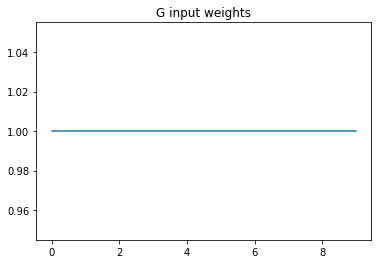

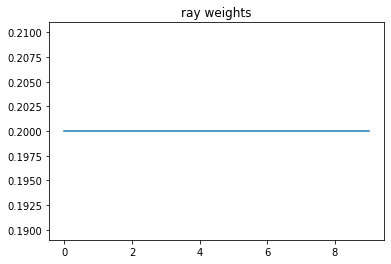

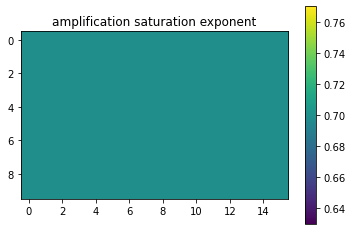

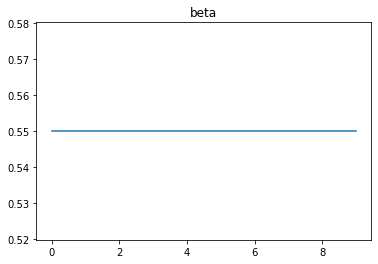

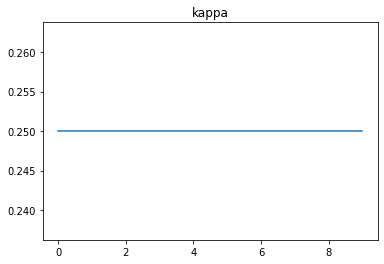

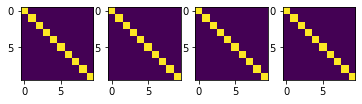

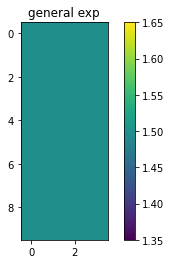

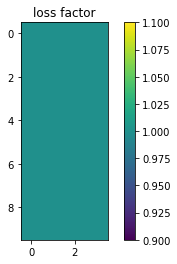

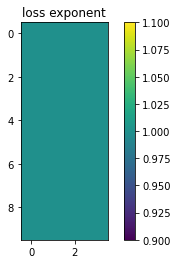

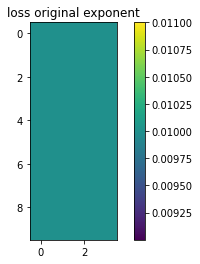

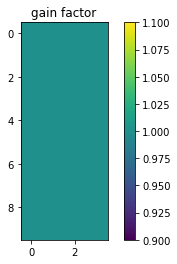

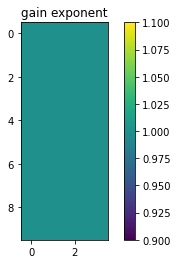

g cells for both letters, max= 59.672283


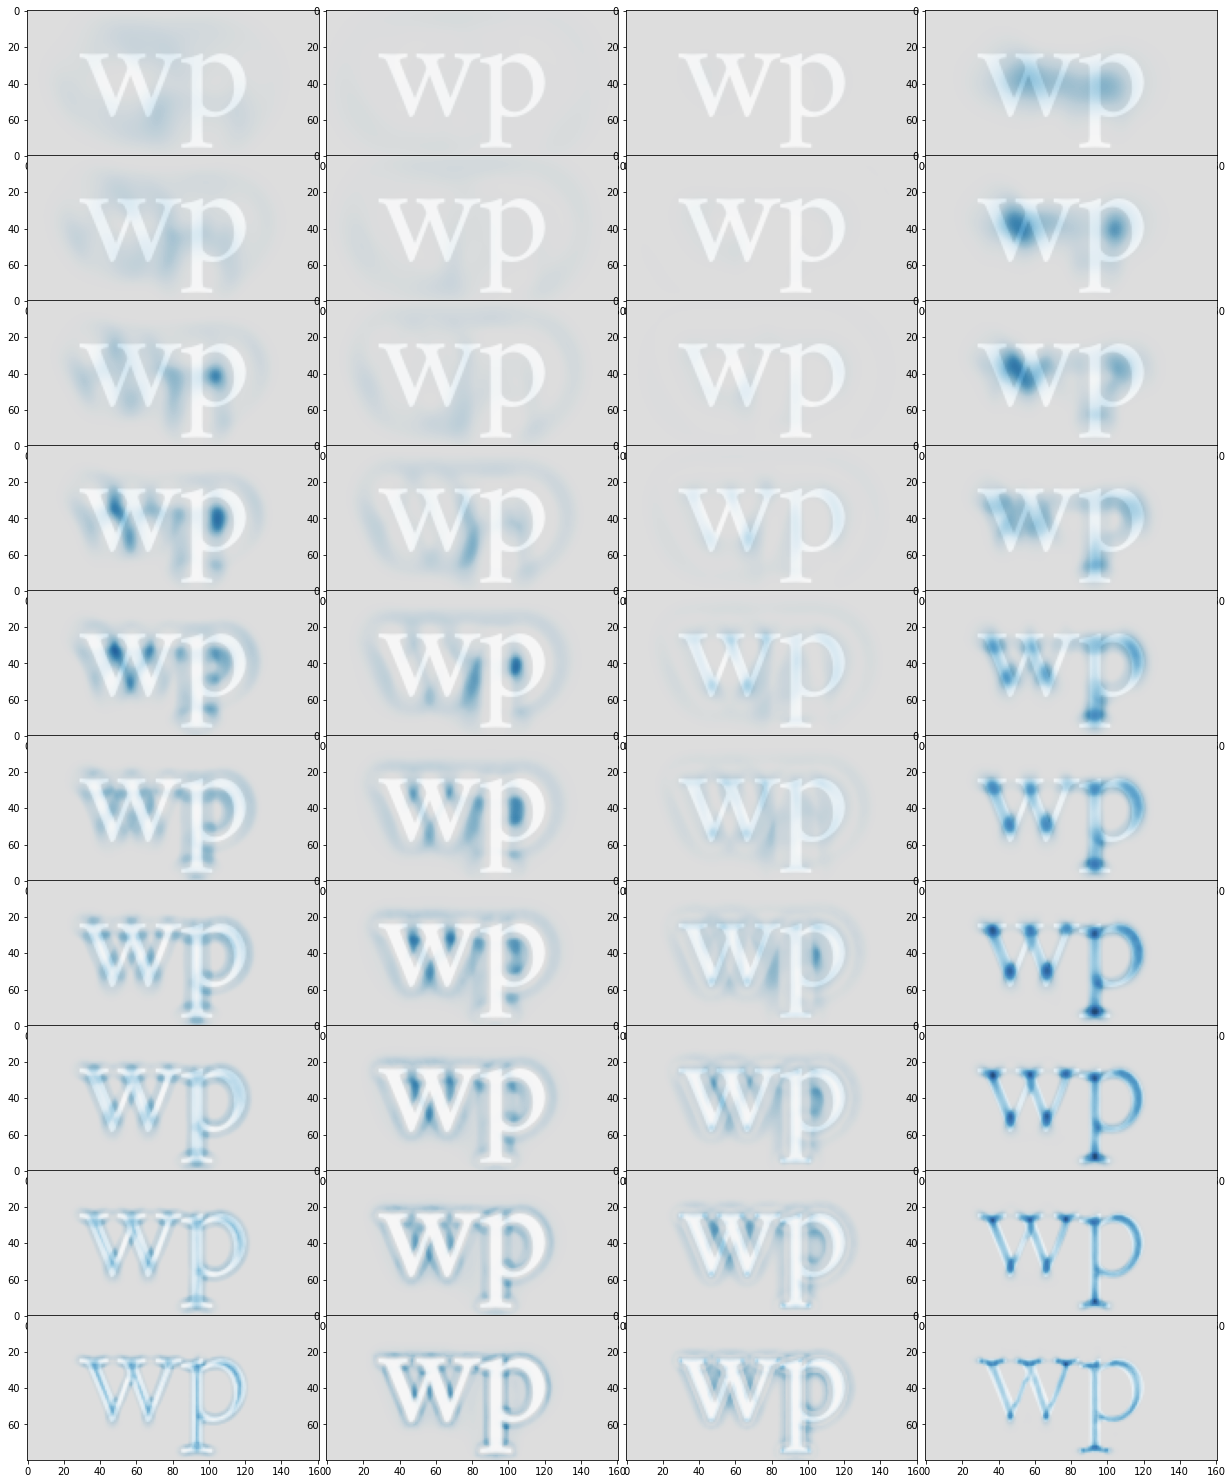

losses, max= 0.36559656


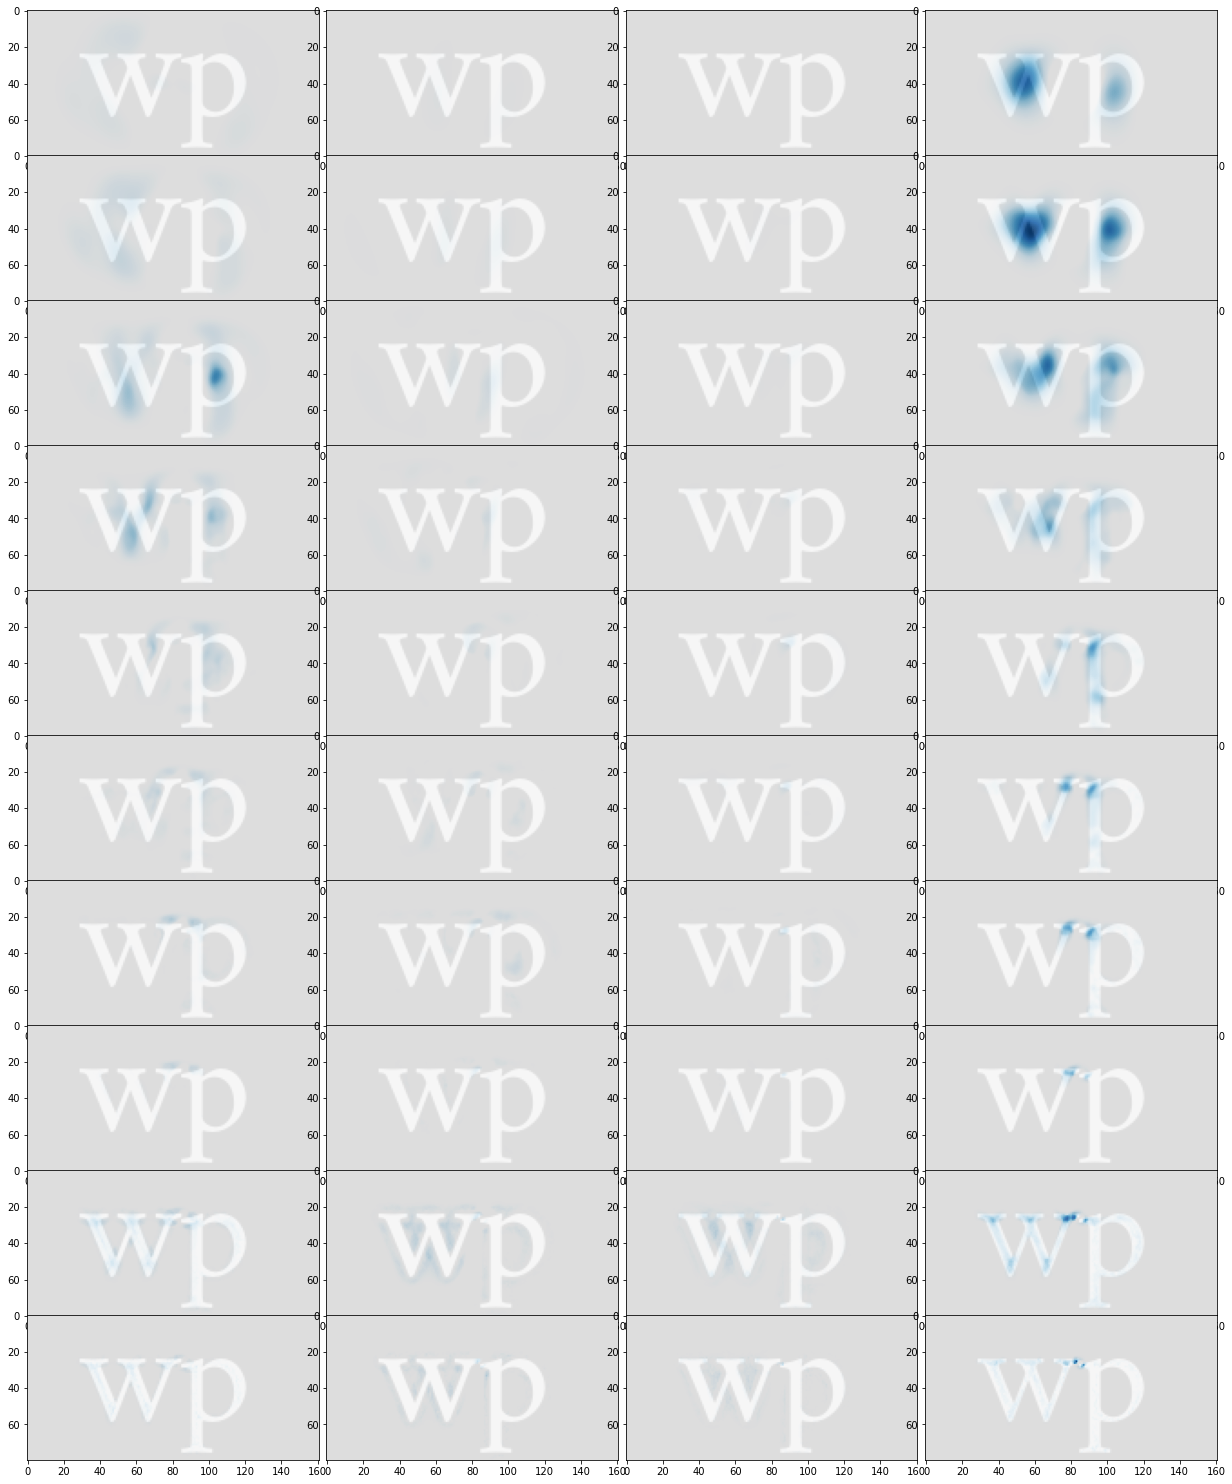

gains, max= 0.3011738


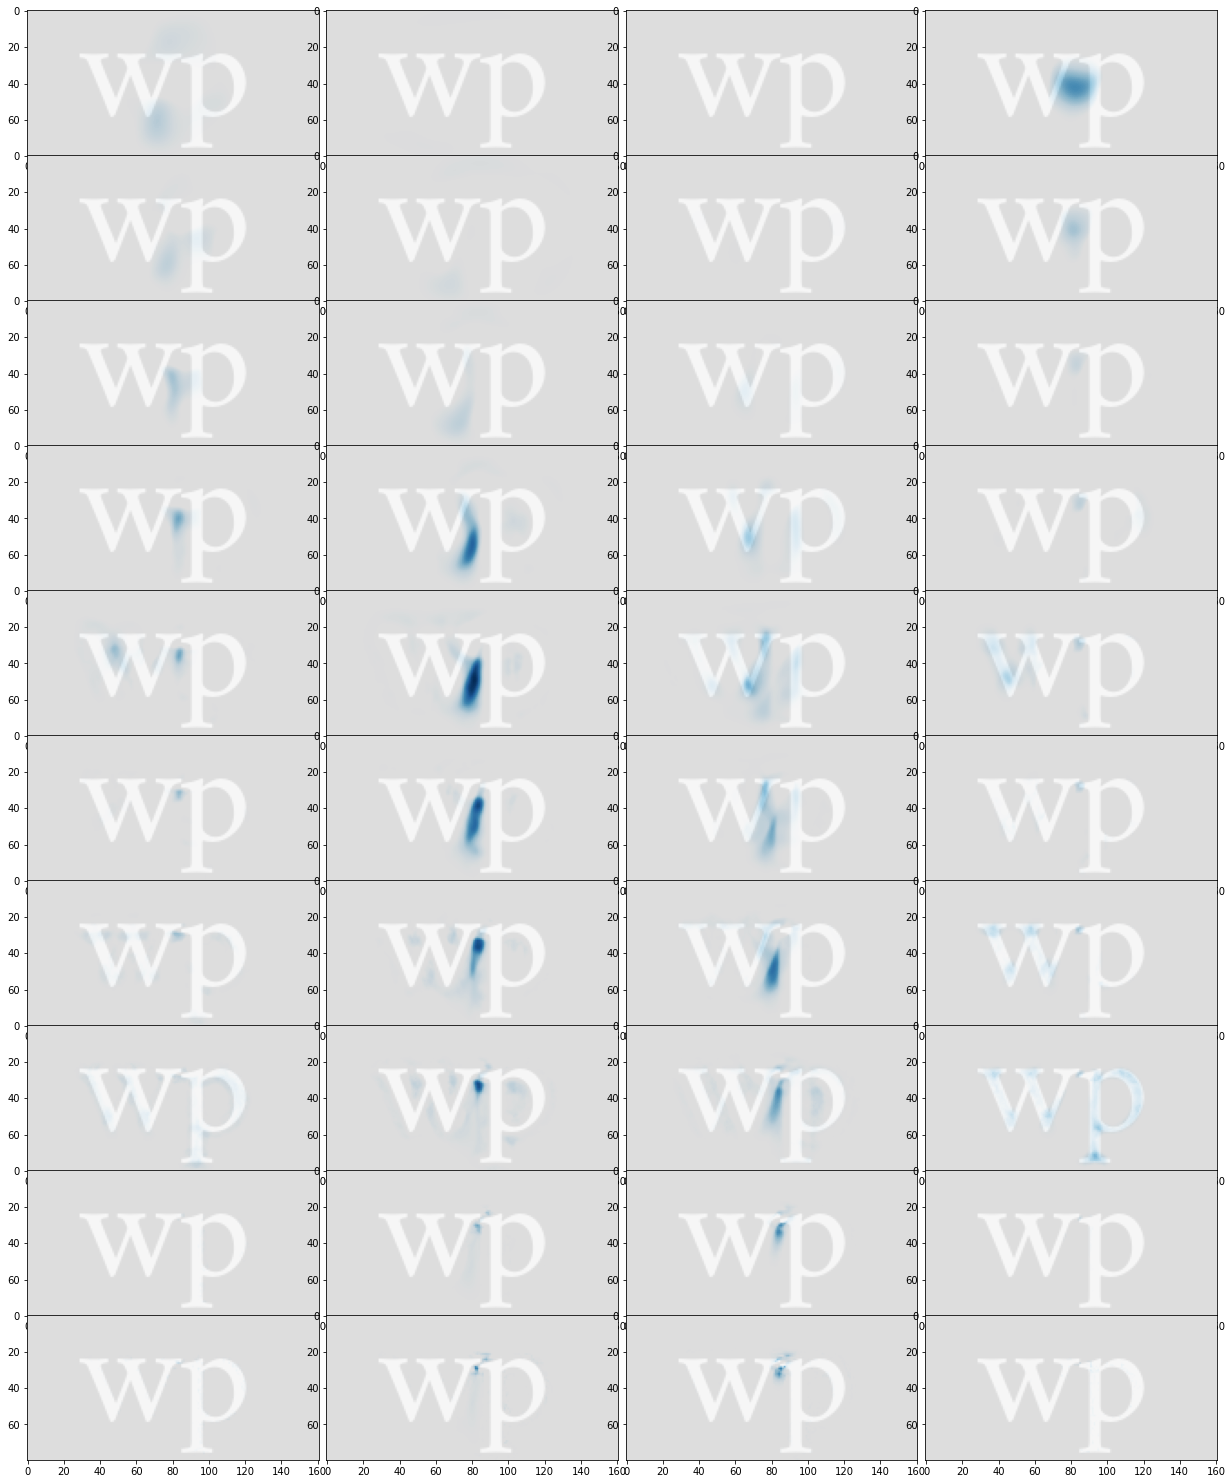

total penalties, max= 0.36559656


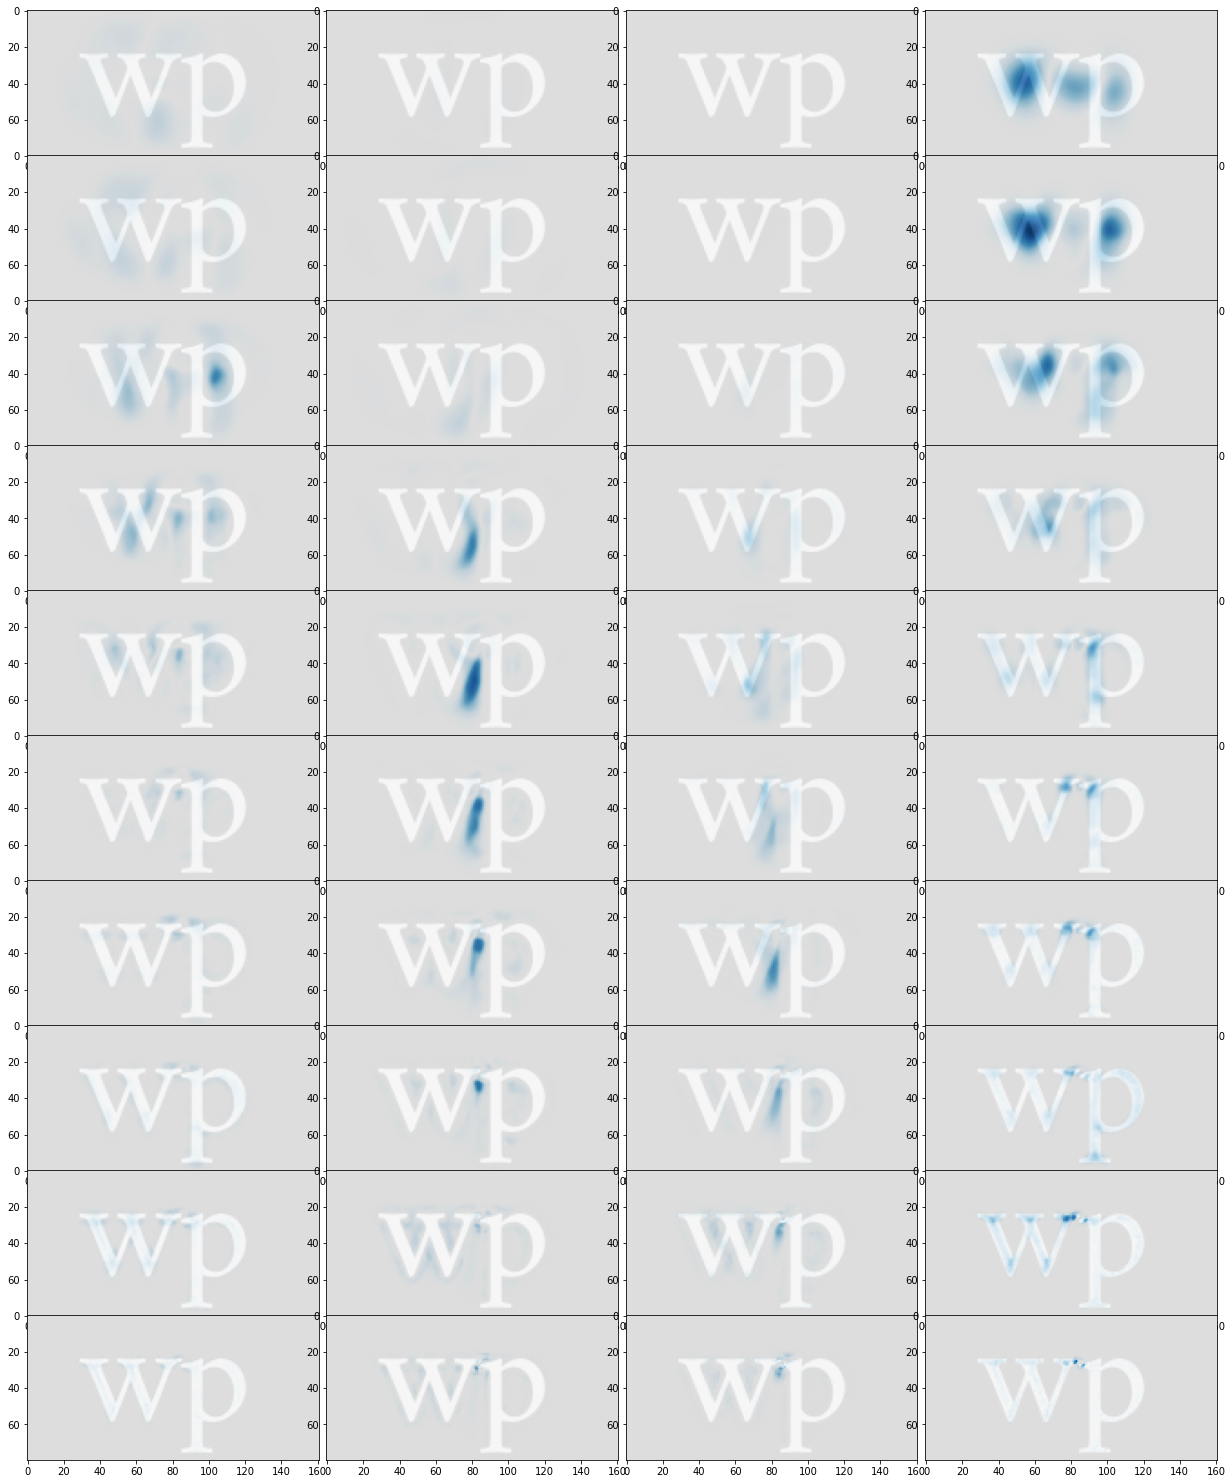

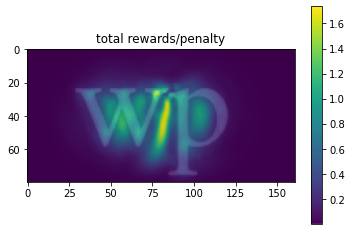

Categorical loss: 287.03174 [[2633.519  2491.22   2417.9023 2356.4155 2130.8706]]
outputs: [[2633.519  2491.22   2417.9023 2356.4155 2130.8706]]
loss: 287.03174 origs: 0.0


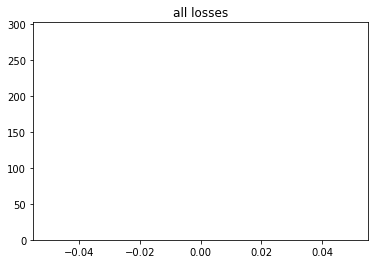

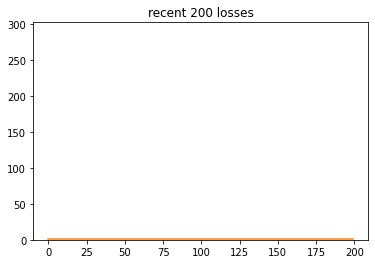

Generating pair h h  ...
Categorical loss: 275.2876 [[2778.1284 2612.3767 2542.1934 2473.481  2266.9058]]
Generating pair d q  ...
Categorical loss: 271.5205 [[2386.4644 2241.3892 2171.5632 2110.0835 1900.0427]]
Generating pair g i  ...
Categorical loss: 297.4818 [[2140.918  1956.8721 1879.8448 1812.3759 1582.363 ]]
Generating pair t u  ...
Categorical loss: 231.87268 [[1782.4707 1631.6189 1567.9519 1514.604  1336.0792]]
Generating pair z y  ...
Categorical loss: 194.78662 [[1602.648  1485.7322 1438.2649 1393.8427 1243.4783]]
Generating pair d j  ...
Categorical loss: 341.19482 [[2180.1277 1985.2197 1895.4108 1810.3356 1554.216 ]]
Generating pair w q  ...
Categorical loss: 133.33374 [[1678.0565 1609.4695 1579.5632 1550.3557 1446.2295]]
Generating pair k m  ...
Categorical loss: 132.86841 [[1825.0217 1755.1804 1725.5061 1700.8417 1592.6377]]
Generating pair v l  ...
Categorical loss: 158.28564 [[1199.2751  1115.0094  1076.3401  1039.6213   918.05444]]
Generating pair r z  ...
Categorica

In [ ]:
# Train the model
try:
    print("memory used before cleanup:", 100 * T.cuda.memory_allocated(0) / T.cuda.get_device_properties(0).total_memory)
except:
    pass
try:
    glyph_pairs.cleanup()
except:
    print("glyph_pairs doesn't exist, couldn't clean up")

try:
    del glyph_pairs
except:
    print("glyph_pairs doesn't exist, couldn't delete")
try:
    yinyangfit.cleanup()
except:
    print("yinyangfit doesn't exist, couldn't clean up")

try:
    del yinyangfit
except:
    print("yinyangfit doesn't exist, couldn't delete")
try:
    del criterion
except:
    print("criterion doesn't exist, couldn't delete")
try:
    del optimizer
except:
    print("optimizer doesn't exist, couldn't delete")
try:
    del outputs
except:
    print("optimizer doesn't exist, couldn't delete")
try:
    del loss
except:
    print("optimizer doesn't exist, couldn't delete")
try:
    del dataloader
except:
    print("dataloader doesn't exist, couldn't delete")

T.cuda.empty_cache()
T.backends.cuda.cufft_plan_cache.clear() 

glyph_pairs = GlyphPairs(end_time=0.002)
dataloader = T.utils.data.DataLoader(glyph_pairs, batch_size=batch_size, shuffle=True)
yinyangfit = YinYangFit().to(dev)

criterion = T.nn.CrossEntropyLoss()
optimizer = T.optim.Adam(yinyangfit.parameters(), lr=0.0022)
T.cuda.empty_cache()
losses = []
log_interval = 50
for epoch in range(5500):  # loop over the dataset multiple times
    print("now in epoch", epoch)
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        #[g1, g2, p1, p2, pg1, pg2, labels] = data
        g1, g2, p1, p2, labels = data  # get back: glyph chars, v1 responses, label. 
        is_log_interval = (i % log_interval == 0) #log_interval - 1)
        if is_log_interval:
            output.clear()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = yinyangfit((p1, p2, g1, g2, is_log_interval))

        #loss = criterion(outputs, labels)
        loss = estimate_min_loss(outputs)

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()
        T.cuda.empty_cache()
        od = outputs.detach().cpu().numpy()
        #if outputs[0, 0] > outputs[0, 1]:
        #    print(g1, g2, "too close (doesn't penalize proximity enough) -- loss", loss.detach().cpu().numpy(), outputs.detach().cpu().numpy())
        #elif outputs[0, 2] > outputs[0, 1]:
        #    print(g1, g2, "too far (doesn't reward the gap properly) -- loss", loss.detach().cpu().numpy(), outputs.detach().cpu().numpy())
        #else:
        #    print("correct -- loss", loss.detach().cpu().numpy())

        if is_log_interval:
            print("outputs:", outputs.detach().cpu().numpy(), flush=True)
            print("loss:", loss.detach().cpu().numpy(), "origs:", np.exp(-loss.detach().cpu().numpy()), flush=True)
            #print("memory used:", 100 * T.cuda.memory_allocated(0) / T.cuda.get_device_properties(0).total_memory)
        #outputs.grad = None
        #labels.grad = None
        # print statistics
        losses.append(loss.item())
        running_loss += loss.item()

        if is_log_interval:
            plt.plot(losses)
            plt.ylim(bottom=0.)
            plt.plot([.69] * len(losses))
            plt.title("all losses")
            plt.show()

        if is_log_interval:
            plt.plot(losses[-200:])
            plt.ylim(bottom=0.)
            plt.plot([.69] * 200)
            plt.title("recent 200 losses")
            plt.show()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    #outputs.detach().cpu()
    #T.cuda.empty_cache()
print('Finished Training')

PATH = './yinyangfit.pth'
T.save(yinyangfit.state_dict(), PATH)





In [ ]:
print("memory used:", 100 * T.cuda.memory_allocated(0) / T.cuda.get_device_properties(0).total_memory)
!nvidia-smi
print(T.cuda.get_device_properties(0).total_memory)